## Part 1: Loading the Data

In [1]:
####
#Loading in necessary libraries, filter out warnings in case old version of Python is used
####
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*") 
#Note: I will sometimes include a reload of a library in later cells, to allow them to be run autonomously, 
#without needing the entire file to be run. 
#Some of the plots can take 2-3 minutes to generate.

In [2]:
#%pip install seaborn --upgrade #N.B. latest version of seaborn is required for this file to work!

In [3]:
###
# 1.1 Loading in the data
###
df = pd.read_csv('data/heart_disease.csv')
df.head(3)
#df.info()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


In [4]:
print(f"Starting Shape: {df.shape}") #(918, 12)
###
# 1.2 Checking for missing values
###
#print(df.isna().sum()) #0 on all
#print(df.isnull().sum()) #0 on all
#print((df=="?").sum()) #0 on all

print(f"Final Shape: {df.shape}") #(918, 16)

Starting Shape: (918, 12)
Final Shape: (918, 12)


## Part 2: Data Cleaning and Pre-Processing

### 2.1 Generating exploratory plots for Appendix 1 and 2

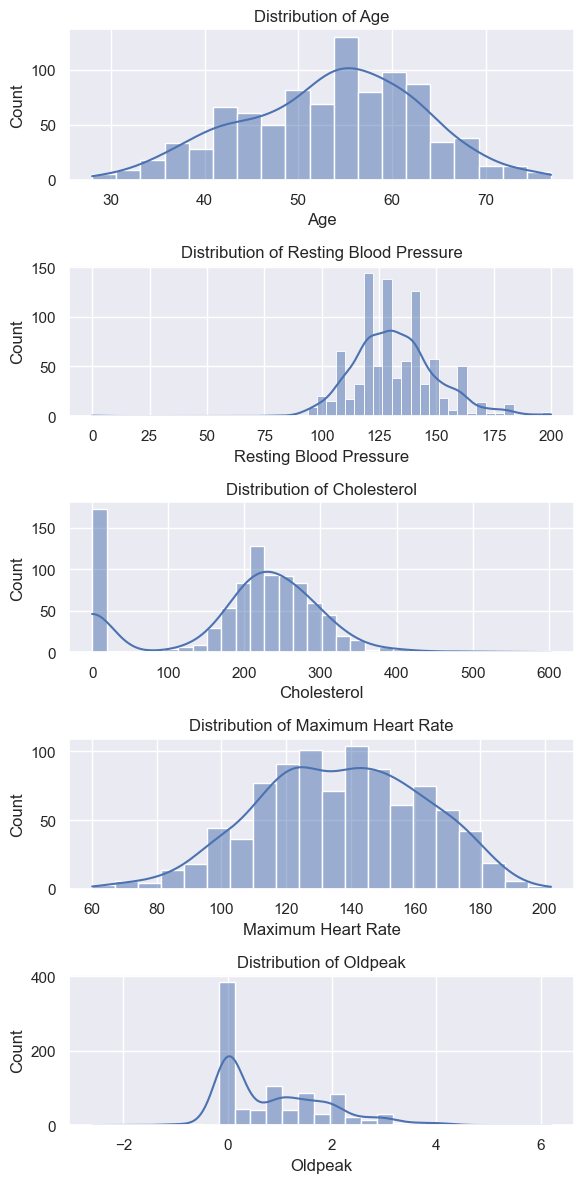

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

continuous_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
plot_names = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Maximum Heart Rate', 'Oldpeak']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 12))
axes = axes.flatten()

#Now, plot each historgram, using a for loop onto the previously created grid of subplots
for i, col in enumerate(continuous_vars):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {plot_names[i]}")
    ax.set_xlabel(plot_names[i])
    ax.set_ylabel("Count")

fig.tight_layout()

#Save it into its respective file (these exist on my local computer, but have been excluded on Github to keep repo clean)
fig.savefig("apendix1.png", dpi=500)

plt.show()  

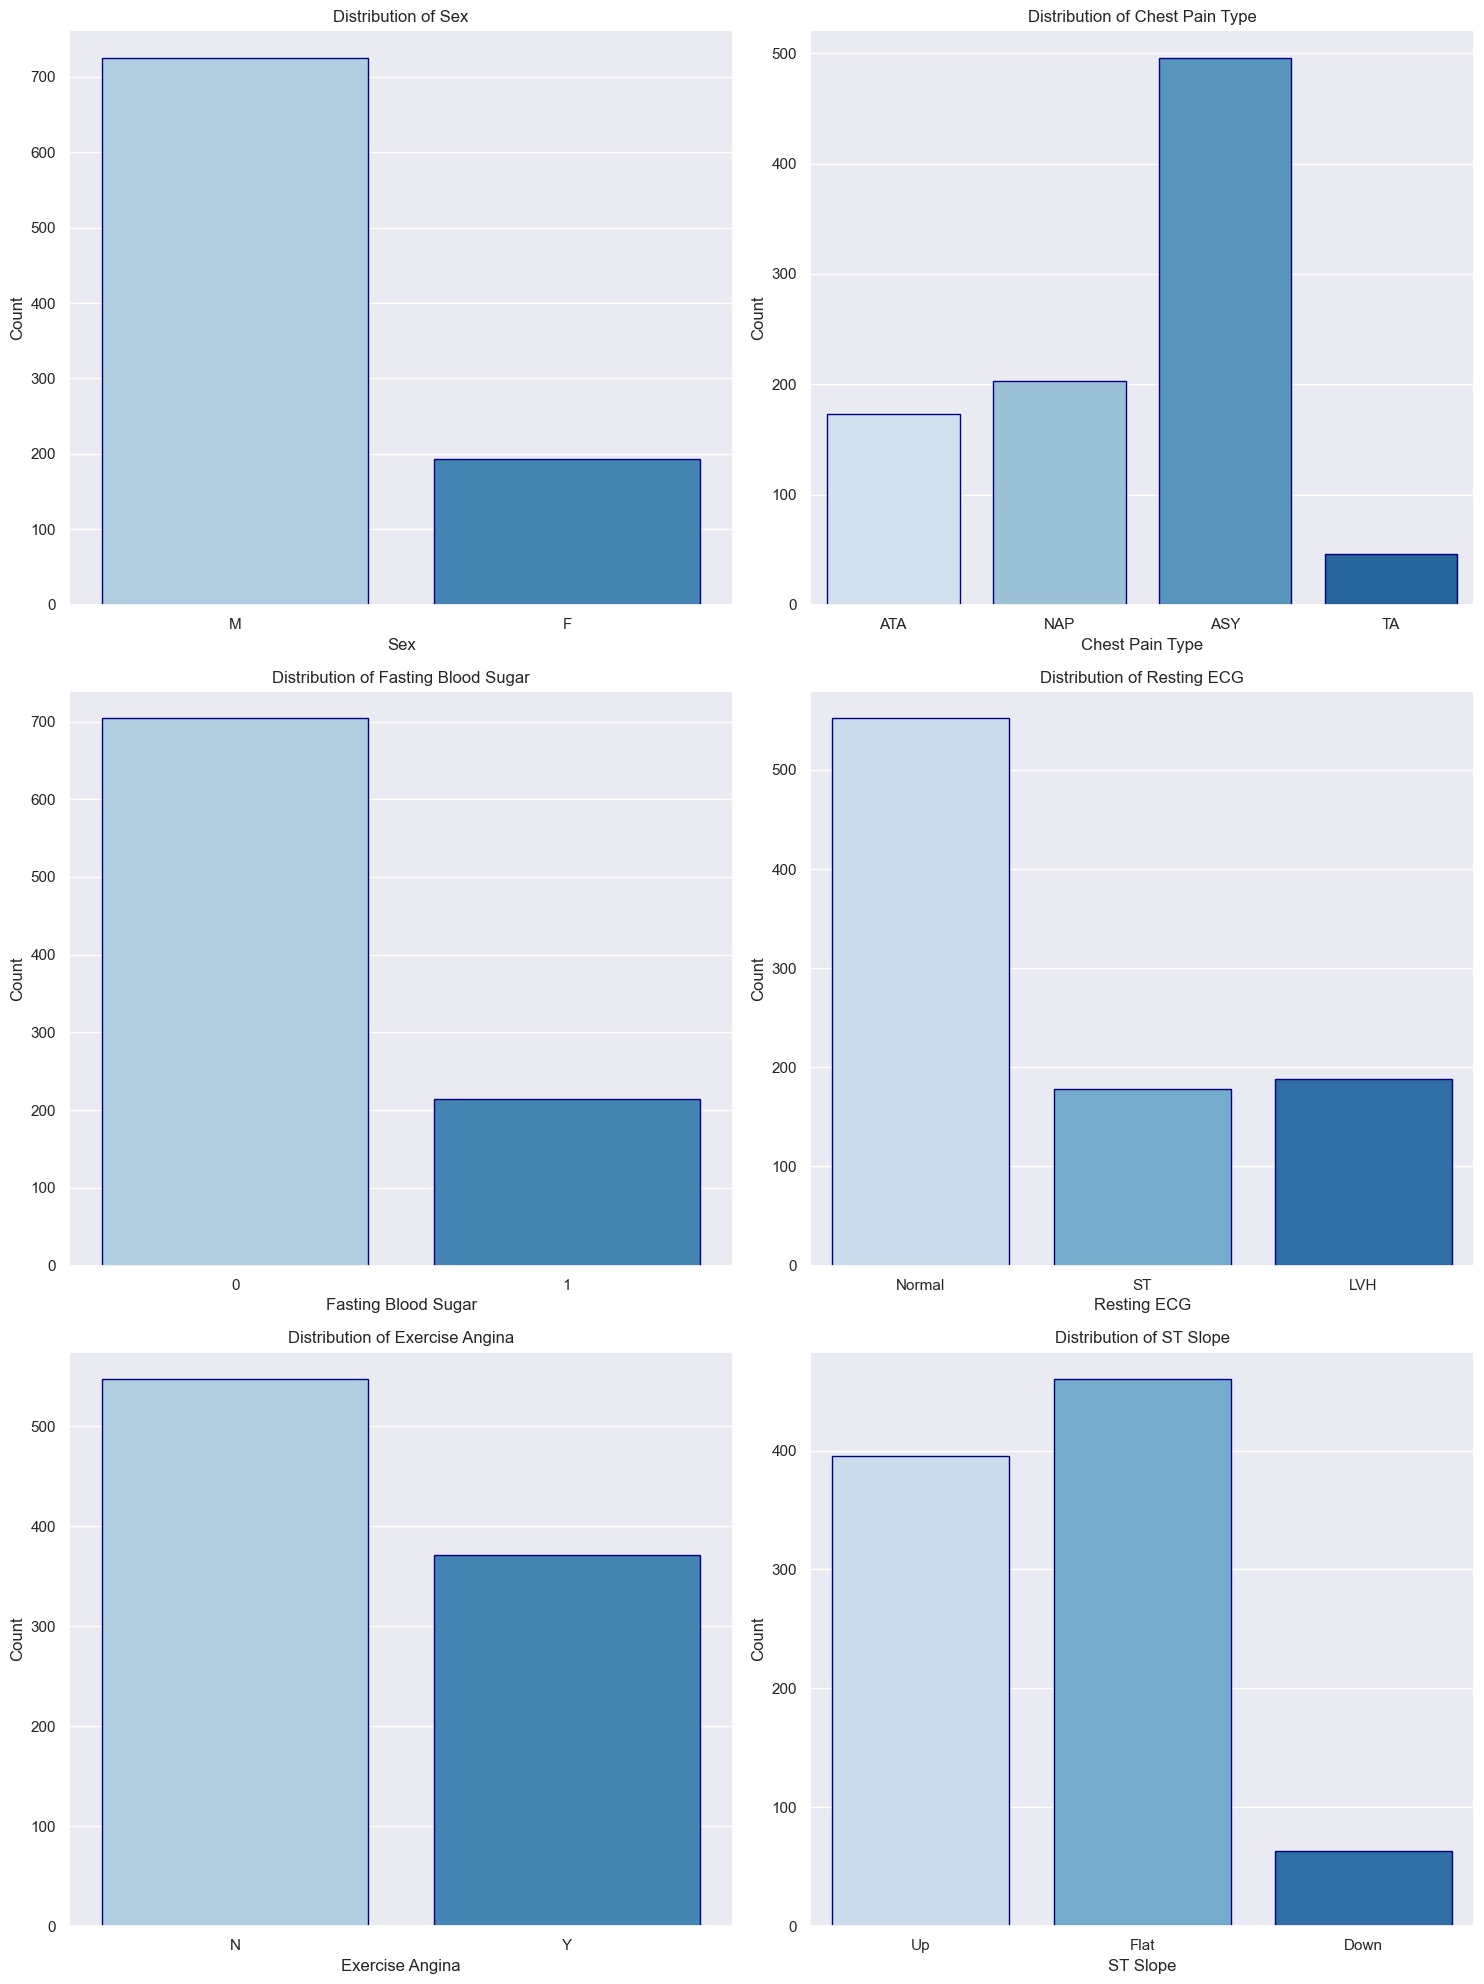

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain the categorical columns
#As this is a plot of features, I also exclude HeartDisease
continuous_vars  = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
categorical_vars = [c for c in df.columns if c not in continuous_vars]
plot_names = ['Sex', 'Chest Pain Type', 'Fasting Blood Sugar', 'Resting ECG', 'Exercise Angina', 'ST Slope']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 20))
sns.set_theme(style="whitegrid")
axes = axes.flatten()  

# Plot each barchart, using a for loop on each subplot
for i, col in enumerate(categorical_vars):
    ax = axes[i]
    sns.countplot(x=col, data=df, hue=col, legend=False,
                  palette="Blues", edgecolor="navy", saturation=0.8, ax=ax)
    ax.set_title(f"Distribution of {plot_names[i]}")
    ax.set_xlabel(plot_names[i])
    ax.set_ylabel("Count")

fig.tight_layout()

#Again, these exist on my local computer
fig.savefig("appendix2.png", dpi=500) 

plt.show()

In [7]:
###
# 2.1 Changing the encoding of variables to numeric.
# ~ Binary Variables are encoded to 0 or 1
# ~ Categorical Variables undergo one-hot encoding
###
#Binary Variable Mapping
df["Sex"]=df["Sex"].map({"M": 1, "F": 0})
df["ExerciseAngina"]=df["ExerciseAngina"].map({"Y": 1, "N": 0})
#Categorical Variable Mapping
df=pd.get_dummies(df, columns=['ChestPainType', "RestingECG", "ST_Slope"], drop_first=True)
#Then, I need to change any encoding to numeric, for the purpose of later model fitting
for col in df.columns:
    if df[col].dtype=="bool":
        df[col]=df[col].astype("int")
#

###
# 2.2 Advanced clearance of missing data
# Importantly, in some datasets missing values are also set to 0, which requires some knowledge to identify
# Here, .describe() higlighted 0 Resting BP and 0 Cholesterol. 
#This is impossible, therefore, signifies missing values
###
#
df['RestingBP'] = df['RestingBP'].replace(0, np.nan)
df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
#print(df.isnull().sum())
#
df['RestingBP_Imputed']=df['RestingBP'].isna().astype(int)
df['Cholesterol_Imputed']=df['Cholesterol'].isna().astype(int)
#
df['RestingBP'].fillna(df['RestingBP'].median(), inplace=True)
df['Cholesterol'].fillna(df['Cholesterol'].median(), inplace=True)
#####
#Update !!!!!
#####
#After further reading, I've decided to remove the imputed samples completely
#
df = df[(df["Cholesterol_Imputed"] == 0) & (df["RestingBP_Imputed"] == 0)].copy()
df.drop(columns=["Cholesterol_Imputed", "RestingBP_Imputed"], inplace=True)
#
print(df.columns)
print(df.shape) #714,16

Index(['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'HeartDisease', 'ChestPainType_ATA',
       'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_Normal',
       'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')
(746, 16)


In [8]:
###
# 2.3 After my final dataset has been created, I can now make a cleaned datafile
# This is included in /data of the Github Repo
###
df.to_csv('data/heart_disease_cleaned_1.csv', index=False)

### 2.2 Generating exploratory plots for Appendix 3 and 4

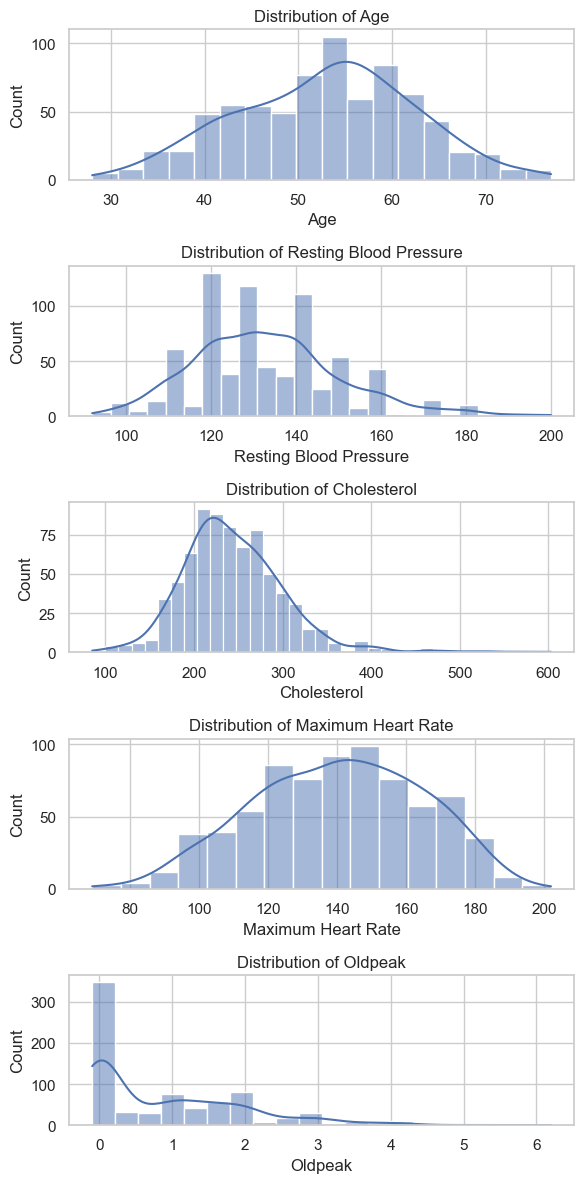

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#This is the same code as section 1, just that the missing data has been filtered out
continuous_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
plot_names      = ['Age', 'Resting Blood Pressure', 'Cholesterol', 'Maximum Heart Rate', 'Oldpeak']

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 12))
axes = axes.flatten()

#Now, plot each historgram, using a for loop onto the previously created grid of subplots
for i, col in enumerate(continuous_vars):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {plot_names[i]}")
    ax.set_xlabel(plot_names[i])
    ax.set_ylabel("Count")

fig.tight_layout()

#Save it into its respective file
fig.savefig("apendix3.png", dpi=500)

plt.show()  

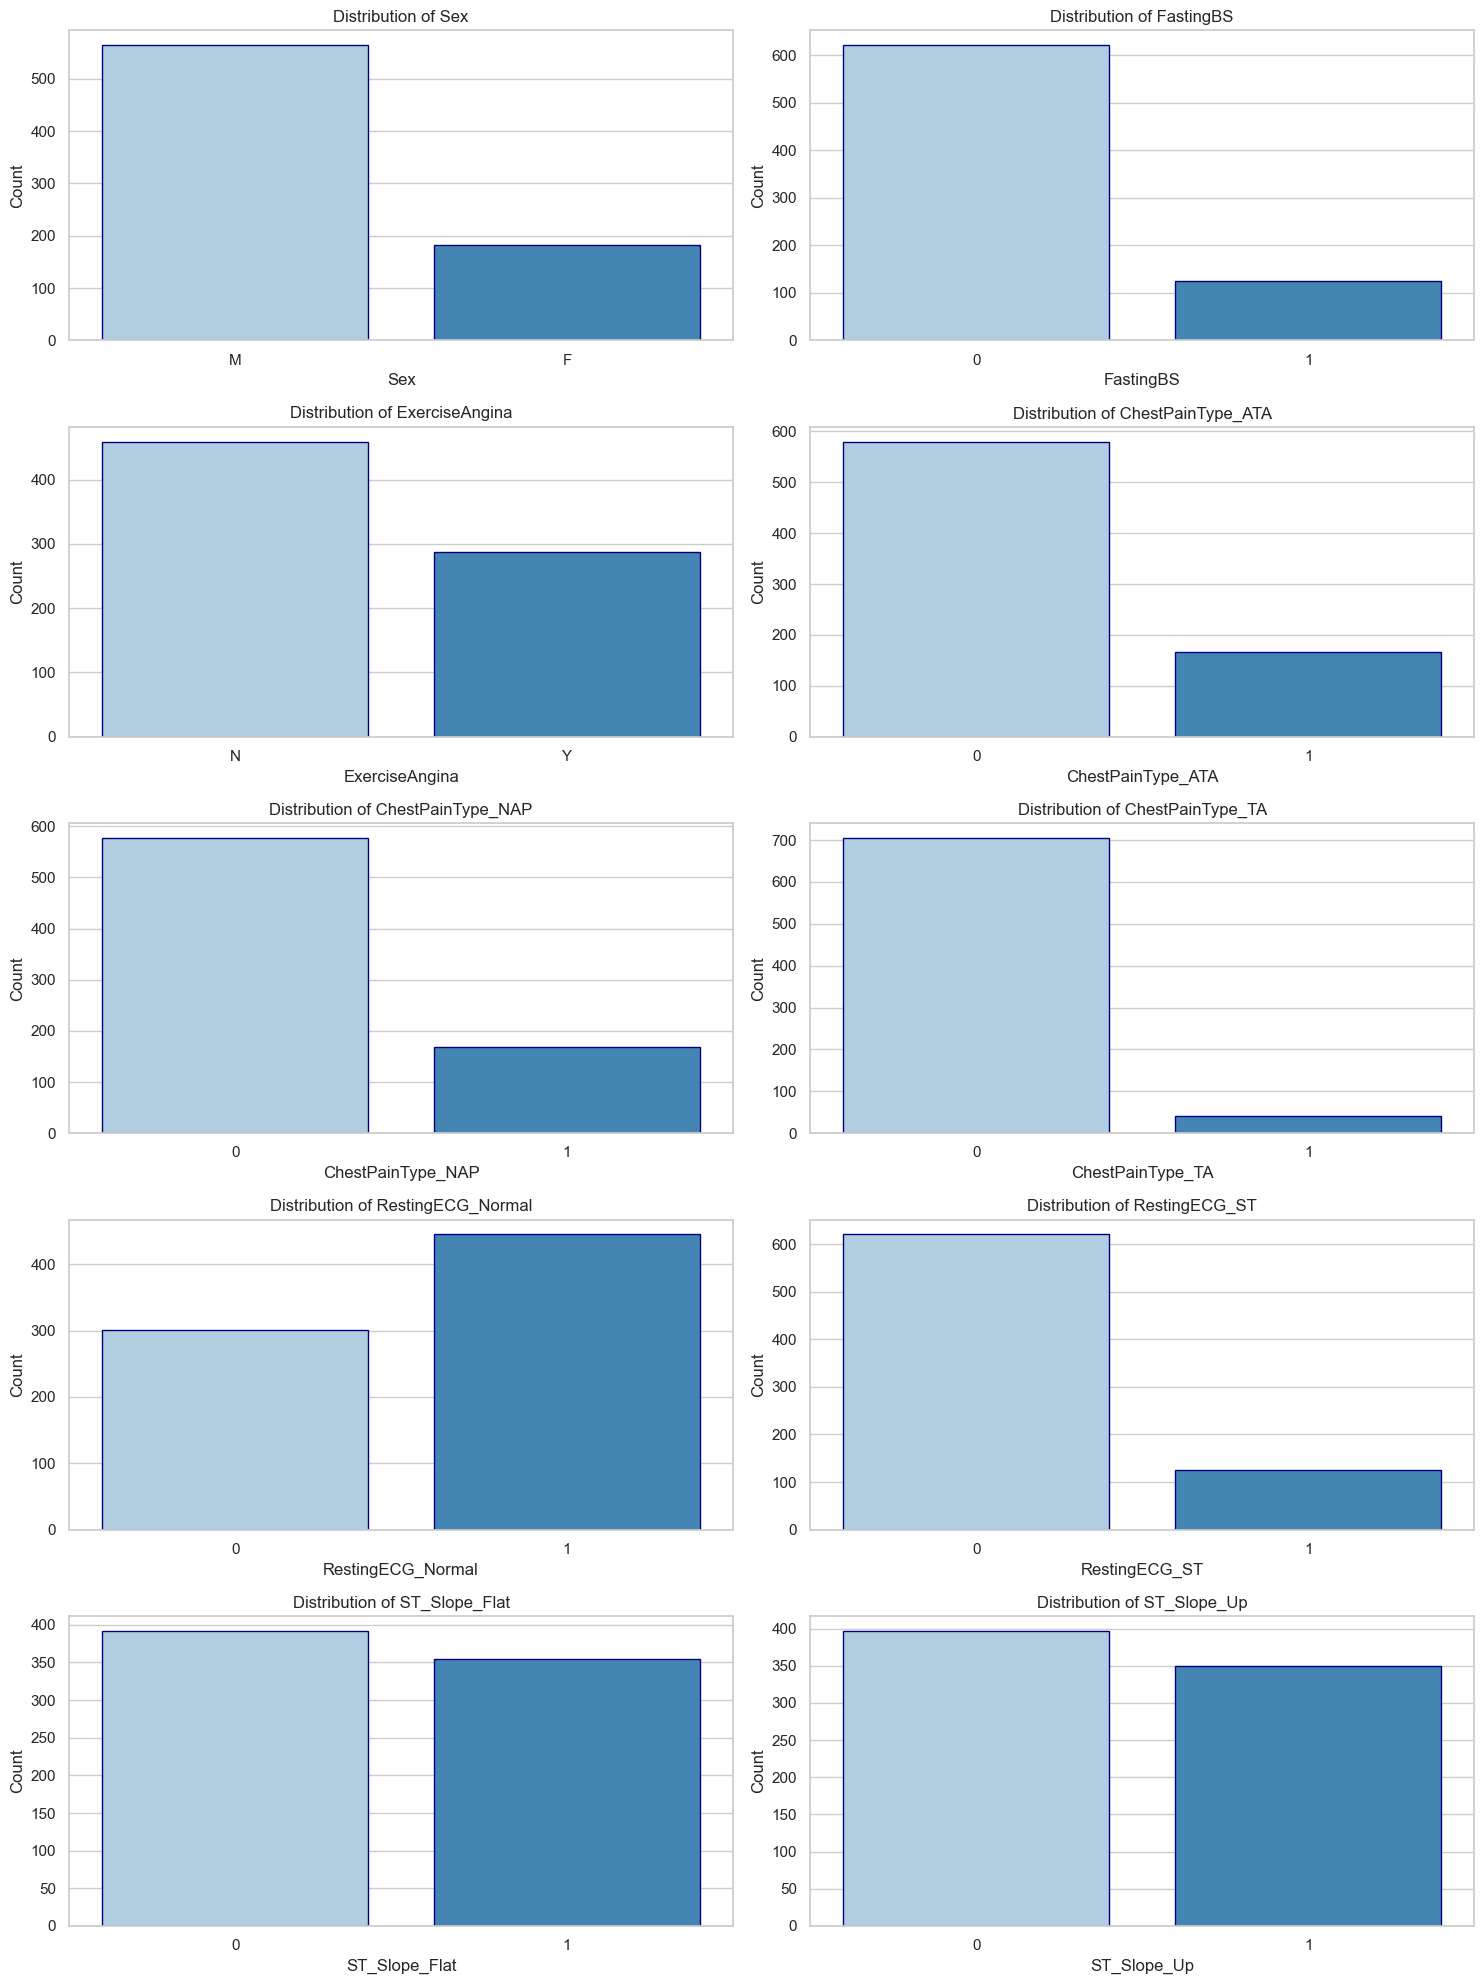

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
#This is the same code as section 1, just that the missing data has been filtered out
df["Sex"]=df["Sex"].map({1: "M", 0: "F"})
df["ExerciseAngina"]=df["ExerciseAngina"].map({1: "Y", 0: "N"})

# Obtain the categorical columns i'm interested in, note here i also am excluding the target variable, since plotting only features
continuous_vars  = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease']
categorical_vars = [c for c in df.columns if c not in continuous_vars]

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
sns.set_theme(style="whitegrid")
axes = axes.flatten()  

# Plot each countplot on its own axis
for i, col in enumerate(categorical_vars):
    ax = axes[i]
    sns.countplot(x=col, data=df, hue=col, legend=False,
                  palette="Blues", edgecolor="navy", saturation=0.8, ax=ax)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

fig.tight_layout()


fig.savefig("appendix4.png", dpi=500) 

plt.show()

## Part 3 Bivariate Plots of Key Variables

### Bivariate Plots of Key Variables, Figures 1 and 2

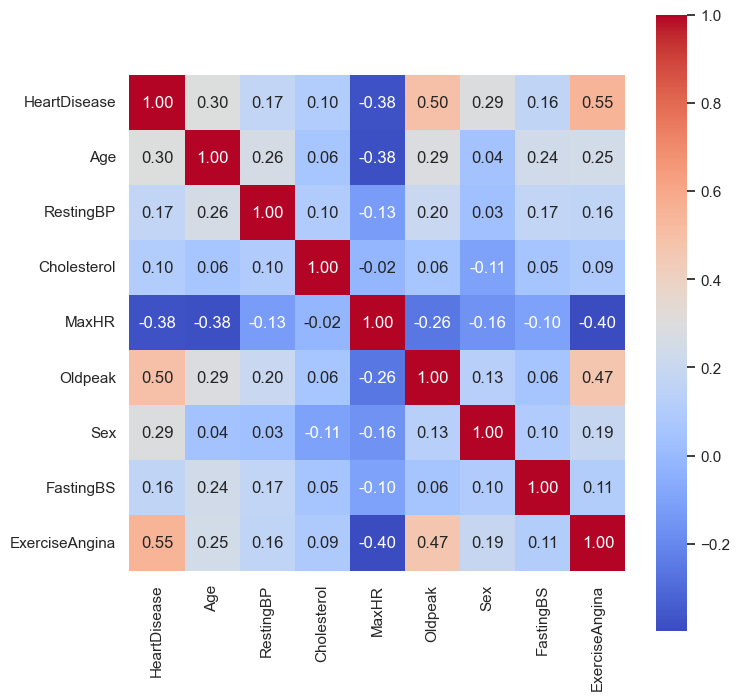

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

#I needed to revert back to categorical (not numeric) for plotting to work.
#Note that this is happening after the cleaned dataset has already been saved to csv file.
df["Sex"]=df["Sex"].map({"M": 1, "F": 0})
df["ExerciseAngina"]=df["ExerciseAngina"].map({"Y": 1, "N": 0})

sns.set_theme(style="white")
#Get the non-one-hot-encoded variables
main_features = [
    'HeartDisease','Age','RestingBP','Cholesterol', 'MaxHR','Oldpeak','Sex','FastingBS','ExerciseAngina'
]

correlation_matrix=df[main_features].corr()

#print(correlation_matrix)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", square=True, fmt=".2f") #Just using the base plot

fig.savefig("fig1.png", dpi=500)

plt.show()

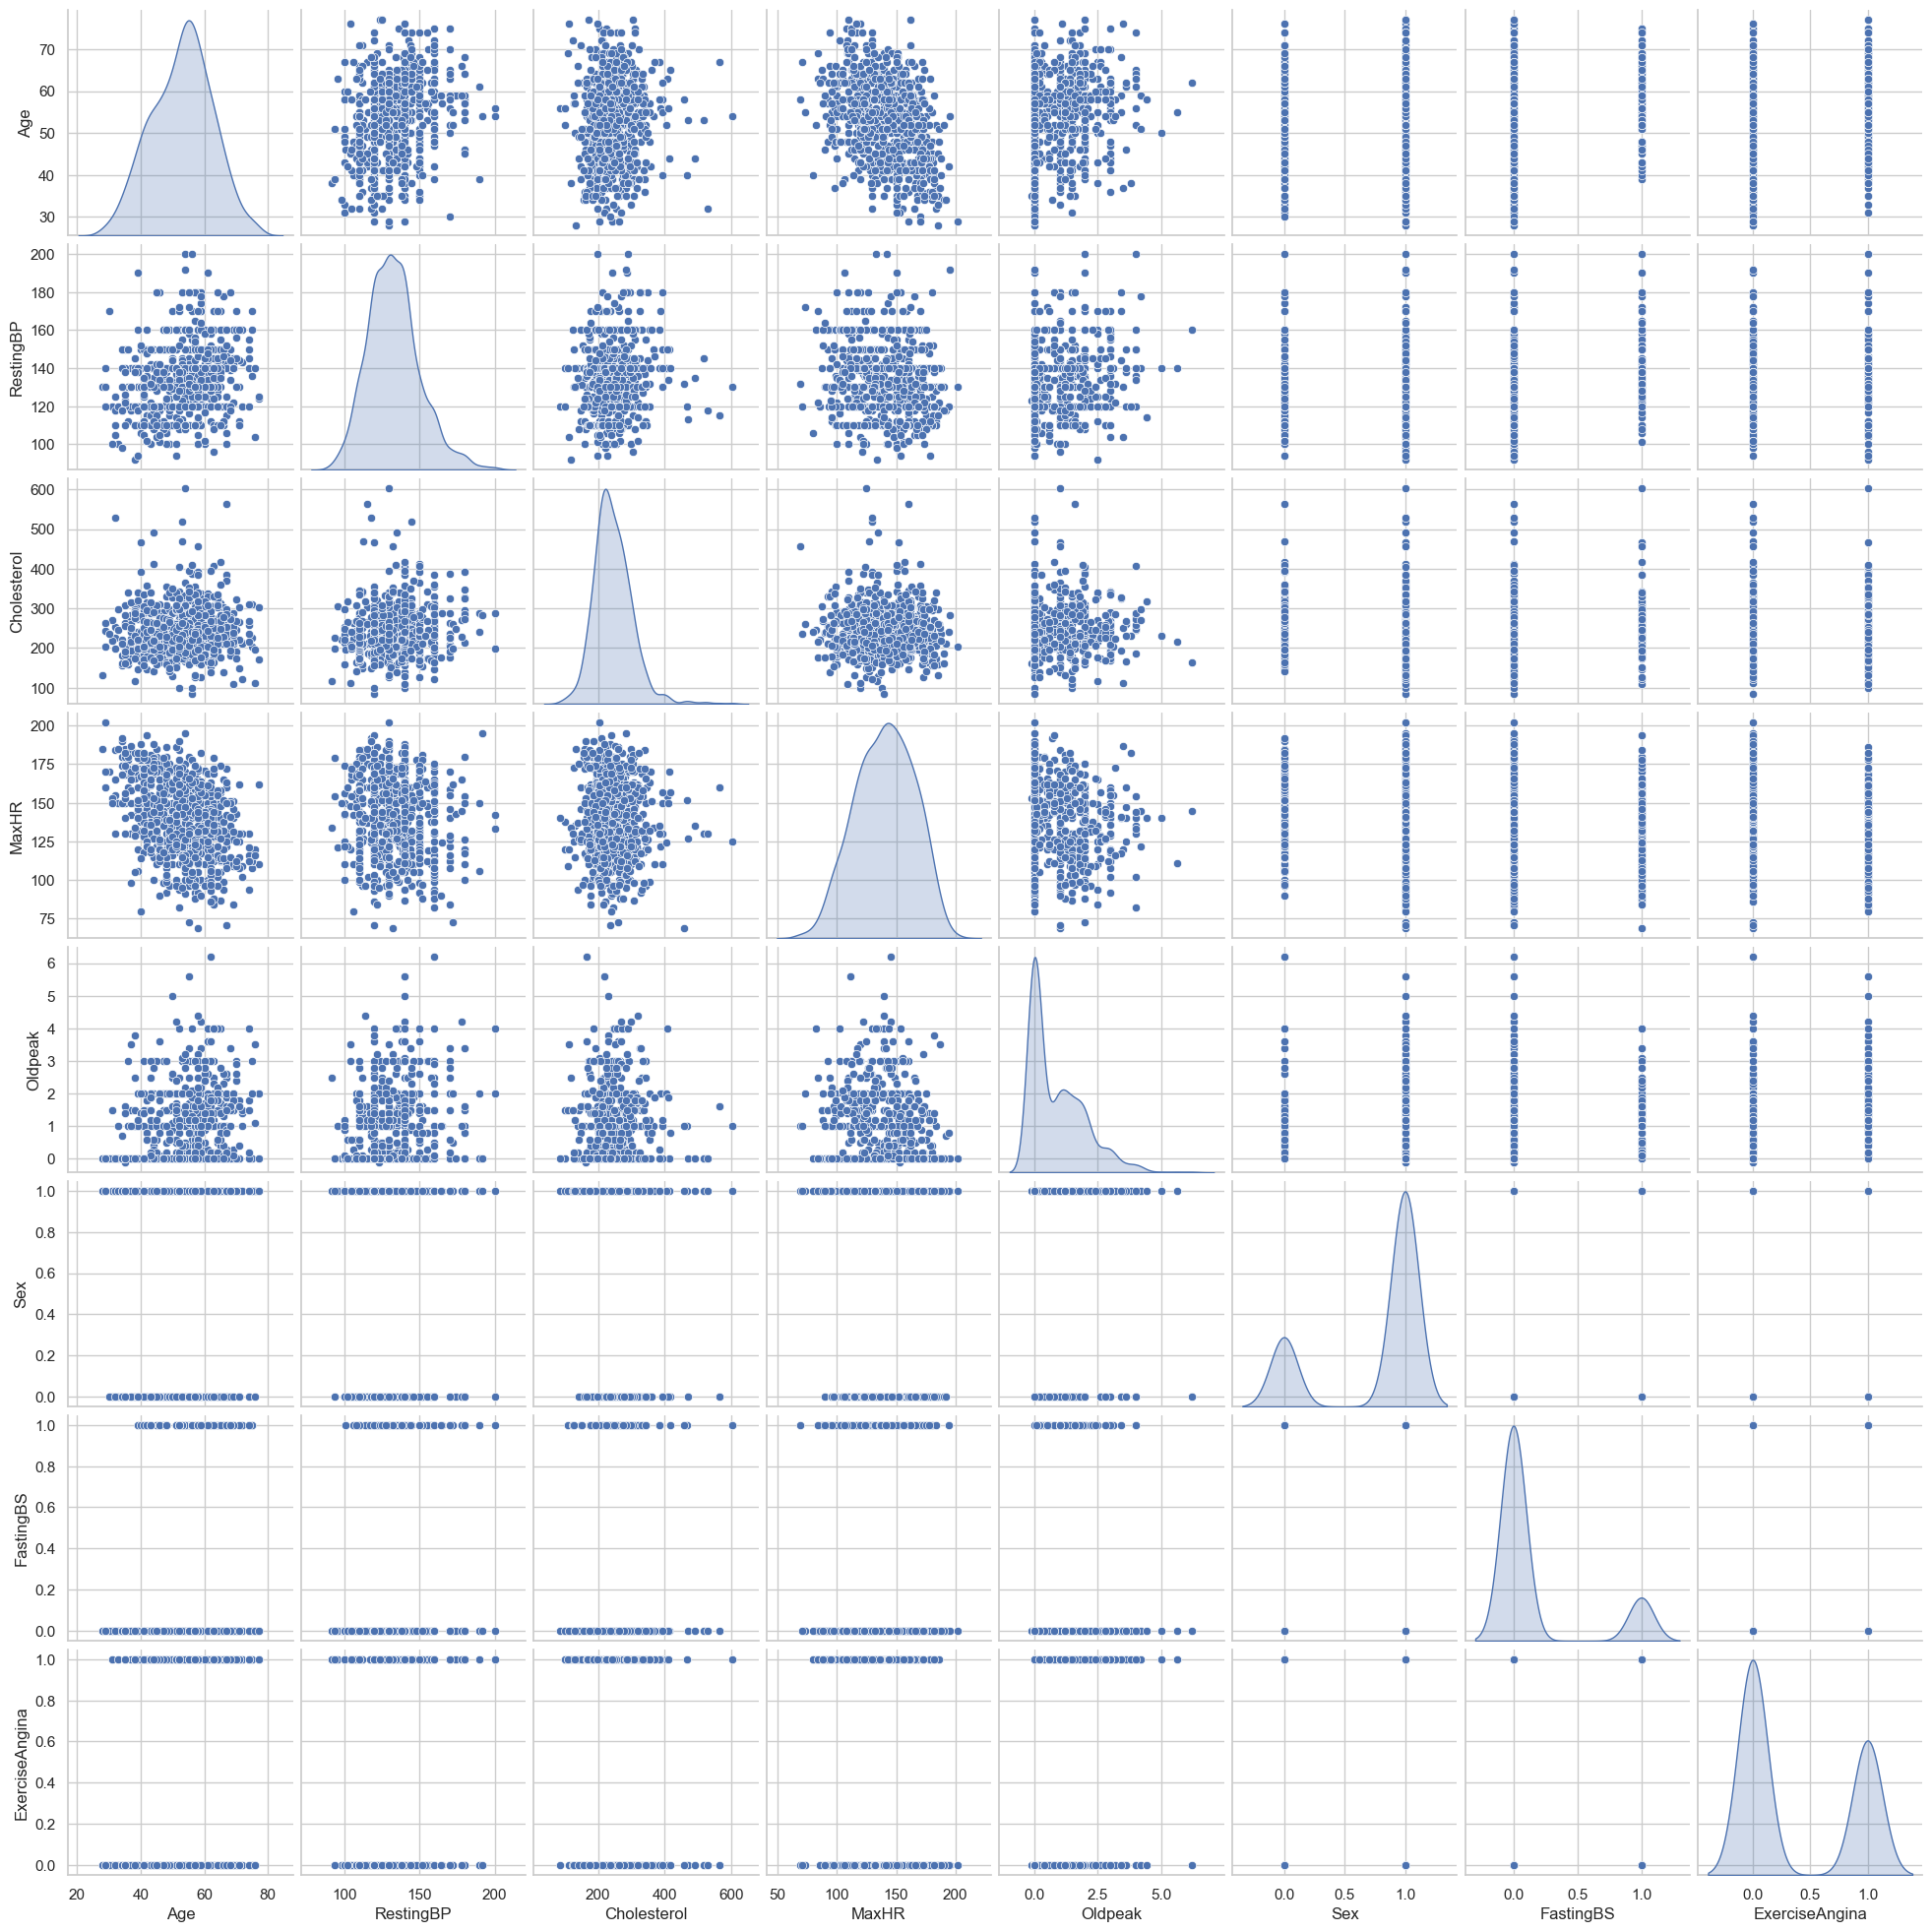

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

######THIS CELL TAKES AROUND 2-3 MINUTES TO RUN!!!!!

main_features = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak','Sex','FastingBS','ExerciseAngina'
]

sns.set_theme(style="whitegrid")
g = sns.pairplot(
    df,
    vars=main_features,
    diag_kind='kde',  
    height=2.5
)

plt.show()

### Bivariate plot  all variables (Appendix 5)

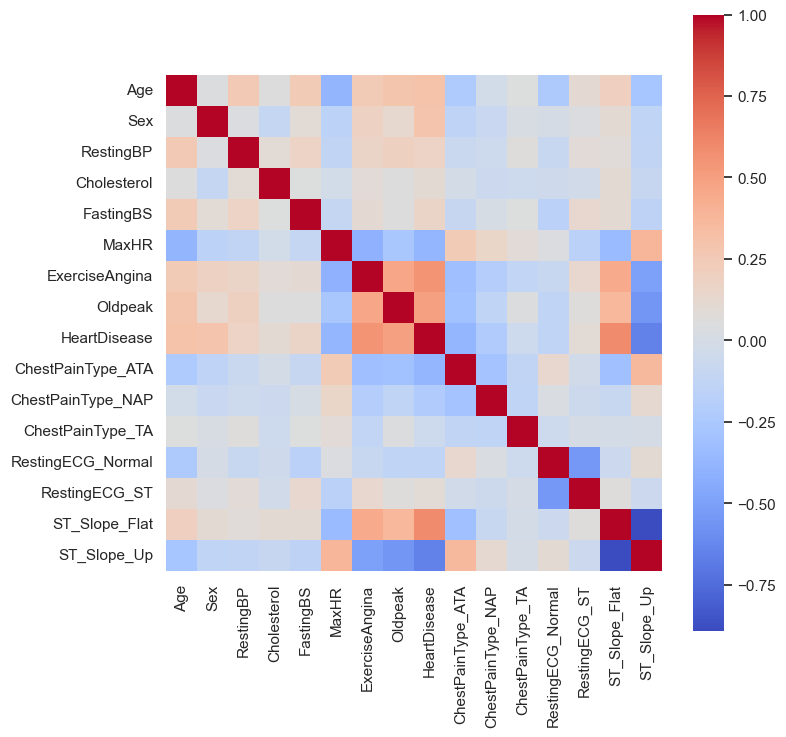

In [13]:
sns.set_theme(style="white")

######THIS CELL TAKES AROUND 2-3 MINUTES TO RUN!!!!!
#This time just run it on the whole dataframe, including one hot encoded variables
#Categorical variable encoding is already corrected for plotting to work from previous cell
plt.figure(figsize=(8, 8))
correlation_matrix=df.corr()


sns.heatmap(correlation_matrix, square=True, cmap="coolwarm", fmt=".2f")
plt.show()